In [1]:
# Reference
# https://yurimkoo.github.io/python/2019/09/14/connect-db-with-python.html

from dotenv import load_dotenv
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from functions.pubgapi import get_tournament_info
from functions.pubgapi import get_match_info
from functions.pubgapi import get_match_participant
from functions.pubgapi import get_match_participant_single
from functions.pubgapi import z_normalization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Load api key & RDS info (endpoint="rds 엔드포인트", dbname="db 이름", username="마스터 사용자 이름", password="rds 비밀번호")
load_dotenv()
api_key = os.environ.get("API_KEY")
endpoint = os.environ.get("AWS_endpoint")
dbname = os.environ.get('AWS_dbname')
username = os.environ.get("AWS_username")
password = os.environ.get("AWS_password")

In [10]:
# 결측치 확인 함수
def print_missing_value(filename, df):
    # 결측치가 발생한 부분에서 log 파일(.csv) 생성
    if (df.isnull().sum()).sum() != 0:
        data.to_csv(f"./Data/Error_log/{filename}.csv")
        raise Exception(f"Missing value: {(df.isnull().sum()).sum()}\nError_log: pubg_api/Data/Error_log/{filename}.csv")

In [15]:
# tournament_info 불러오기
tournament_info = get_tournament_info(api_key)
print_missing_value('tournament_info', tournament_info)

for tournament_index in range(6,8): # len(tournament_info["id"])
    # index 설정 및 해당 인덱스의 tournament_id 값 불러오기
    tournament_name = tournament_info["id"][tournament_index]
    tournament_createdAt = tournament_info["createdAt"][tournament_index]

    # cur_match_info(Current match info) 불러오기
    cur_match_info = get_match_info(api_key, tournament_name)

    # match_participant_single 불러오기
    for match_index in range(len(cur_match_info["matchId"])):
        match_participant_single = get_match_participant_single(api_key, cur_match_info["matchId"][match_index])
        print_missing_value(cur_match_info["matchId"][match_index], match_participant_single)

        # Z-score normalization 수행
        data = z_normalization(match_participant_single)

        if os.path.isfile("./Data/Train_data/train_match_data.csv"):
            # 해당 경로에 train_match_data.csv가 있으면, 현재 내용을 해당 파일에 추가
            train_data = pd.read_csv(f"./Data/Train_data/train_match_data.csv")
            train_data.drop(["Unnamed: 0"], axis = 1, inplace = True)
            train_data = pd.concat([train_data, data], ignore_index=True)
            train_data.to_csv(f"./Data/Train_data/train_match_data.csv")
        else:
            # 해당 경로에 train_match_data.csv가 없으면, 파일 생성
            data.to_csv(f"./Data/Train_data/train_match_data.csv")

In [16]:
data = pd.read_csv(f"./Data/Train_data/train_match_data.csv")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)

data.isnull().sum()

dbnos            0
assists          0
boosts           0
damage_dealt     0
heals            0
kill_streaks     0
kills            0
longest_kill     0
revives          0
time_survived    0
win              0
dtype: int64

<AxesSubplot:>

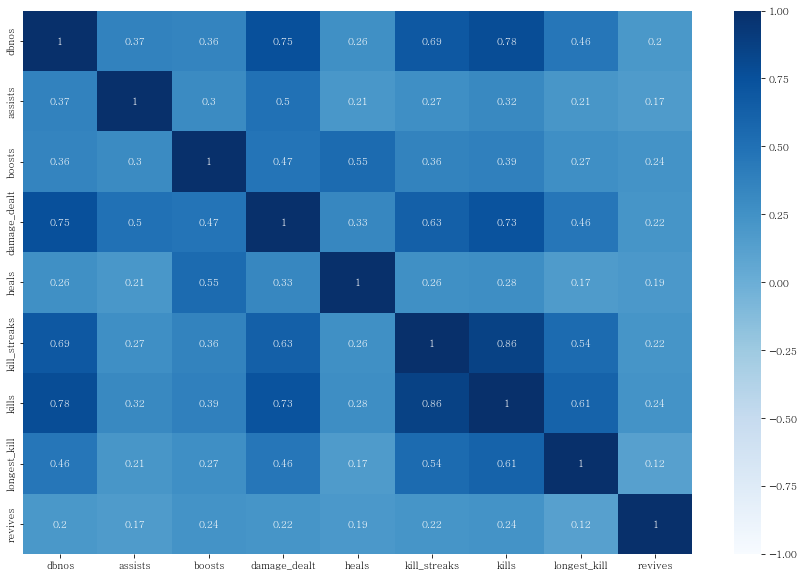

In [42]:
# https://tjansry354.tistory.com/13
import seaborn as sb

data_corr = data[z_label]

plt.rcParams['figure.figsize']=(15,10)
sb.heatmap(data_corr.corr(), annot=True, cmap='Blues', vmin = -1, vmax = 1)

<AxesSubplot:>

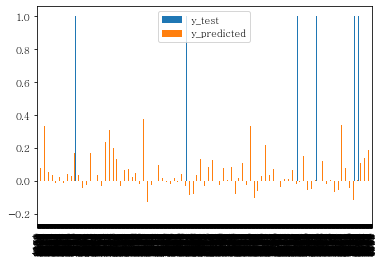

In [36]:
# linear regression
# https://tjansry354.tistory.com/12?category=927195
# y 값을 cal_round_point_int 로 바꾸기

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

data = pd.read_csv(f"./Data/Train_data/train_match_data.csv")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)


# 학습 데이터와 테스트 데이터로 분리합니다.
#'선수명', 'y'를 제외한 칼럼들은 X
X = data[data.columns.difference(['win'])]
y = data['win']

#검증(test)는 20%로 한다. = test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 회귀 분석 객체 생성(선형 회귀 모델 생성)
lr = linear_model.LinearRegression()

#fit()는 기울기와 절편을 전달하기 위함.
model = lr.fit(X_train, y_train)

# 학습된 계수를 출력합니다.
# print(lr.coef_)

# 상수항을 출력합니다.
# print(lr.intercept_)

x_new=X_test
y_new=model.predict(x_new)

y_compare={'y_test':y_test, 'y_predicted':y_new}

pd.DataFrame(y_compare).plot(y=['y_test', 'y_predicted'], kind="bar")

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.935
특성 중요도 : 
[0.0959879  0.12842985 0.10852822 0.15707432 0.09751039 0.08423145
 0.12913116 0.11333421 0.0857725 ]


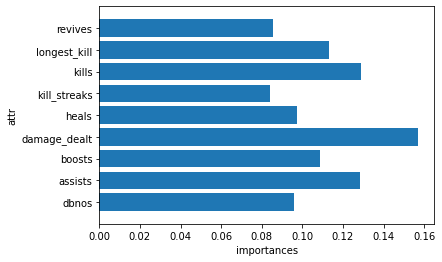

In [19]:
# Random Forest
z_label = (["dbnos", "assists", "boosts", "damage_dealt", "heals", "kill_streaks", "kills", "longest_kill", "revives"])
X = data[z_label]
y = data["win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train,y_train)

print("훈련 세트 정확도 : {:.3f}".format(forest.score(X_train,y_train)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(X_test,y_test)))

print("특성 중요도 : \n{}".format(forest.feature_importances_))

# 특성 중요도 시각화 하기
def plot_feature_importances(model):
    n_features = len(z_label)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), z_label)
    plt.xlabel("importances")
    plt.ylabel("attr")
    plt.ylim(-1, n_features)
plt.show()

plot_feature_importances(forest)

In [20]:
mvp_feature = (forest.feature_importances_)*data[z_label]
data["mvp_feature"] = mvp_feature.sum(axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

data.sort_values(["mvp_feature"], ascending=False)

dbnos   assists    boosts  damage_dealt     heals  kill_streaks  \
1549  3.629101  3.940904  3.322684      2.859612  0.367383      4.894222   
501   3.916379  2.034471  1.842105      4.606453 -0.696987      3.372642   
2118  5.034798  3.363147  2.556166      3.923002  1.985203      2.341042   
2714  4.441487  3.557654  0.466136      4.458380 -0.247704      3.664736   
6689  5.246083  2.046760  3.382477      4.786490  2.200446      3.112864   
3454  1.723359  4.136726  3.684003      3.349554  3.165421      2.248595   
5470  4.306241  0.643726  2.679836      4.503759  0.783725      3.510627   
5638  4.166704  4.506849  0.992562      2.953497  0.235925      0.718185   
3352  2.365877  5.879747  2.032932      2.984048  0.590289      2.079898   
4155  4.215414  1.851640  2.987334      3.671528  1.226695      3.221945   
2880  2.787849  3.227248  3.564081      2.895301  4.203506      1.779793   
2626  3.419270  2.656279  1.765475      3.670569  0.446150      1.979596   
1386  4.055072  0.776750  2.452750      3.420742  0.969925      2.127417   
1590  3.915885  1.733621  2.783386      3.049131  0.454778      2.897473   
2890  3.476738  3.227248  2.222310      4.377804  0.459628      3.017911   
1259  4.607213  4.259104  0.705596      3.133434  1.584082      1.903988   
6347  5.529634  2.846550  0.746203      5.184664 -0.282604      2.608616   
5081  5.199469  2.987730  1.565853      4.909657 -0.190693      0.642311   
5791  3.114280  2.273978  0.196297      4.419488 -0.873294      2.508674   
307   4.926675  2.102791  2.313536      4.197328  0.132691      3.718125   
8783  3.741853  3.850547  2.098892      4.550368 -0.096449      2.266257   
3623  1.871926  5.070597  1.580304      4.414653  1.170279      2.113335   
8655  3.520073 -0.750479  2.143506      3.110930  1.082356      0.689730   
1952  4.171268  4.470211  0.680731      4.200665  1.763420      1.791422   
3849  3.436612  3.067110  2.013485      5.205218  0.279670      2.459748   
6961  1.943114  2.320154  2.490107      1.282727  2.013688      2.147485   
1877  4.010512  2.245554  1.091842      2.305773  1.411500      2.202456   
3356  3.895332  0.534522  2.032932      3.966201  1.209608      2.079898   
746   4.335572 -0.489821  2.223413      3.436055  2.354383      3.939818   
2241  4.232823  4.367305 -0.223394      3.911460  1.332623      2.164827   
8173  2.744781  2.244790  2.649926      3.451047  1.592361      0.907393   
1129  3.458516  2.264670  1.506229      2.195859 -0.389699      3.446147   
3261  4.274653  2.404081  1.059863      4.007048 -0.456654      1.960429   
9395  1.791839  3.224814 -0.197008      2.376300 -0.300576      3.650497   
5259  5.375888 -0.565685  1.548854      3.675122  1.234345      2.183063   
4993  2.506226  5.517732  0.332348      3.202053  2.401441      0.718185   
5333  1.579744  4.801352  2.386980      3.293268  0.027180      1.721127   
8203  3.915885  1.848070  0.580877      2.909488  0.754890      3.134220   
4461  2.590101  5.284874  1.808126      2.850812  1.382794      2.465859   
1727  4.535129  2.303726  1.272292      4.135221  0.106928      1.936324   
1178  2.215266 -0.621150  0.932312      3.959503  1.992088      3.807195   
9337  2.329579  1.108338  2.031667      3.894345  0.819696      2.040920   
8931  2.850884  4.849294  1.532995      2.939913 -0.284930      1.590783   
4460  5.089093  2.369081  1.808126      3.254636  1.067852      0.750479   
1879  1.641225  2.245554  1.488875      2.447395  2.041019      2.202456   
974   3.556791  0.205806  1.424131      4.445107  2.204978      2.128626   
7558  4.594463  2.598171  0.408430      3.352093  0.691277      1.906203   
529   4.662172  2.263010  0.774130      3.864268  2.061934      0.643712   
8898  3.465857  0.289820  1.519109      3.389656 -0.205714      2.040920   
915   2.761454  2.060355  0.848629      3.462234  1.476706      2.040433   
528   2.331086  2.263010  1.828263      2.773721  3.330817      3.390214   
1451  2.900283  1.698636  3.454884      1.976681  0.77926